This notebook contains the experimental pipeline for spatial data of MS stations. The main goal is to train regression models based on the features of current and voltage. The prediction goal is the active and reactive power. The first half of the notebook contains pre-processing. It uses the df_IU and df_PQs that were created from the ems data in the ems_metingen_data_reshape notebook. Similar to temporal data some pre-processing is done here, mostly change the date times to usable integer time stamps.

In [1]:
import pyarrow.feather as feather
import pandas as pd
from datetime import datetime
import numpy as np
import math
import time

import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
df_IU = feather.read_feather('df_IU.feather')
df_PQ = feather.read_feather('df_PQ.feather')

In [3]:
df_IU.fillna(0, inplace=True)
df_PQ.fillna(0, inplace=True)

In [22]:
df_IU

,DATUM_TIJD,STATION,I_0,U_0,I_1,U_1,I_2,U_2,I_3,U_3,...,I_20,U_20,I_21,U_21,I_22,U_22,I_23,U_23,I_24,U_24
0,0.0,Tex,0.000000,0.0105,76.790000,0.0105,44.380000,0.0105,52.980000,0.0105,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
1,0.0,Hby,2.080332,0.0105,25.878577,0.0105,2.743656,0.0105,9.843535,0.0105,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
2,0.0,Dtn,65.649983,0.0105,45.709995,0.0105,6.767125,0.0105,0.000000,0.0000,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
3,0.0,HFDP,0.000000,0.0210,0.000000,0.0210,127.780000,0.0210,126.570000,0.0210,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
4,0.0,Grd,0.000000,0.0105,56.730000,0.0105,57.390000,0.0105,0.000000,0.0105,...,0.0,0.0105,22.19,0.0105,56.78,0.0105,395.0,0.0105,28.77,0.0105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051014,105119.0,Tex,0.690000,0.0105,0.000000,0.0105,35.670000,0.0105,76.100000,0.0105,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
1051015,105119.0,HFDP,0.000000,0.0210,0.000000,0.0210,205.380000,0.0210,146.010000,0.0210,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
1051016,105119.0,Dtn,5.948891,0.0105,53.075207,0.0105,0.000000,0.0000,0.000000,0.0000,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000
1051017,105119.0,Hby,9.789142,0.0105,15.129863,0.0105,0.000000,0.0105,2.743656,0.0105,...,0.0,0.0000,0.00,0.0000,0.00,0.0000,0.0,0.0000,0.00,0.0000


In [4]:
# converts a time amount in 'nanoseconds' to an amount in '5 minutes'
def ns_to_5m(x):
    return x/(pow(10,9)*60*5)

In [5]:
# sort values on "DATUM_TIJD"
df_IU = df_IU.sort_values("DATUM_TIJD")
df_PQ = df_PQ.sort_values("DATUM_TIJD")

# .value returns time in nanoseconds, starting form unix time.
# Get starting timestamp and convert this to '5 minutes'
start_time = ns_to_5m(df_IU["DATUM_TIJD"].iloc[1].value)

# Convert each DATETIME timestamp to a float value representing the amount of 5 minutes since start time
df_IU["DATUM_TIJD"] = df_IU['DATUM_TIJD'].apply(lambda x: ns_to_5m(x.value)-start_time)
df_PQ["DATUM_TIJD"] = df_PQ['DATUM_TIJD'].apply(lambda x: ns_to_5m(x.value)-start_time)

df_IU = df_IU.reset_index(drop=True)
df_PQ = df_PQ.reset_index(drop=True)

In [6]:
# Reduce timescale
def weeks_to_5_mins(weeks):
    return int(12*24*7*weeks)

def reduce_timescale(df, weeks):
    weeks = weeks_to_5_mins(weeks)
    df = df[df["DATUM_TIJD"] <= weeks]
    return df

In [7]:
  
# alpha = 10
def GaussianProcess_regression(X_train, y_train, X_test, alpha=10):
    model = GaussianProcessRegressor(alpha = alpha)
    model.fit(X_train, y_train)

    predict = model.predict(X_test)
    df_predict = pd.DataFrame(predict, columns = y_train.columns, dtype = float)
    return df_predict

def XGboost_regression(X_train, y_train, X_test):
    model = XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)

    predict = model.predict(X_test)
    df_predict = pd.DataFrame(predict, columns = y_train.columns, dtype = float)
    return df_predict

In [8]:
def predict_sign(df_predict, y_test):
    df_sign = df_predict.copy()
    df_y_sign = y_test.copy()
    for col in df_sign.columns:
        df_sign[col] = df_sign[col].apply(lambda x: -1 if x<0 else 1)
        df_y_sign[col] = df_y_sign[col].apply(lambda x: -1 if x<0 else 1)

    df_new_sign = df_sign == df_y_sign
    
    field_accuracies = []
    for col in df_new_sign.columns:
        field_accuracies.append(df_new_sign[col].value_counts(normalize=True).values[0])

    P_accuracies = field_accuracies[::2]
    Q_accuracies = field_accuracies[1::2]
    
    P_avg = sum(P_accuracies)/len(P_accuracies)
    Q_avg = sum(Q_accuracies)/len(Q_accuracies)
    
    return P_avg, Q_avg

In [9]:
# Calculates the dead space, or the amount of 0s present in the dataset
def calc_percentage_dead_space(Xs):
    dead_space = np.zeros(len(Xs))
    total = Xs[0].stack().value_counts().sum()
    for index, df in enumerate(Xs):
        zeros = df.stack().value_counts()[0]
        dead_space[index] = zeros/total
    return dead_space



# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size, limit): 
    chunks = list()
    df = df[df["DATUM_TIJD"] <= limit]
    entries_per_5_min = df[df["DATUM_TIJD"]==0].shape[0]
    print(chunk_size)
    num_chunks = len(df) // (chunk_size*entries_per_5_min) 
    # removed +1 above because otherwise it would be 27 chunks
    
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
    

# splits the data on stations, creating a data subset for each station
# amount of data taken from each station specified with weeks
# limit is the amount of samples desired per split. Useful for quick test runs
def split_on_stations(df_IU, df_PQ, weeks, limit=0):
    if limit == 0:
        limit = df_IU.shape[0]
    
    df_IU = df_IU[df_IU["DATUM_TIJD"] <= limit]
    df_PQ = df_PQ[df_PQ["DATUM_TIJD"] <= limit]
    
    df_IU = reduce_timescale(df_IU, weeks)
    df_PQ = reduce_timescale(df_PQ, weeks)
    
    stations = df_IU["STATION"].unique()

    dfs_IU = []
    dfs_PQ = []

    for station in stations:
        temp_IU = df_IU[df_IU["STATION"]==station]
        temp_PQ = df_PQ[df_PQ["STATION"]==station]

        del temp_PQ["DATUM_TIJD"]
        del temp_IU["STATION"], temp_PQ["STATION"]
        
        temp_PQ#.reset_index(drop = True, inplace = True)
        temp_IU#.reset_index(drop = True, inplace = True)

        dfs_IU.append(temp_IU)
        dfs_PQ.append(temp_PQ)
        
    print(len(dfs_IU))
    
    return dfs_IU, dfs_PQ


# splits the data in equal parts of depending on the desired amount of weeks
# limit is the amount of samples desired per split. Useful for quick test runs
def split_on_weeks(df_IU, df_PQ, weeks, limit=0):   
    if limit == 0:
        limit = df_IU.shape[0]
    
    dfs_IU = split_dataframe(df_IU, weeks_to_5_mins(weeks), limit)
    dfs_PQ = split_dataframe(df_PQ, weeks_to_5_mins(weeks), limit)
    
    for index in range(len(dfs_IU)):
        temp_IU = dfs_IU[index]#.reset_index(drop=True)
        temp_PQ = dfs_PQ[index]#.reset_index(drop=True)
        
        del temp_PQ["DATUM_TIJD"]
        del temp_IU["STATION"], temp_PQ["STATION"]
        
        dfs_IU[index] = temp_IU
        dfs_PQ[index] = temp_PQ
    
    return dfs_IU, dfs_PQ
    

# performs cross validation on the split datasets of Xs and ys.
# Metrics preserved are sign accuracy and mse, which are returned in a 2D result matrix
def cross_validation(Xs, ys):
    matrix = np.zeros((len(ys),len(ys),2))
    alpha = 10
    for x_index, X_train in enumerate(Xs):
        y_train = ys[x_index]
        for y_index, y_test in enumerate(ys):
            print("X: {0}, Y: {1}".format(x_index, y_index))
            X_test = Xs[y_index]
            df_predict = XGboost_regression(X_train, y_train, X_test)
            
            P,_ = predict_sign(df_predict, y_test)
            mse = mean_squared_error(y_test, df_predict)
            
            matrix[x_index, y_index, 0] = P
            matrix[x_index, y_index, 1] = mse
            
    return matrix


## Cross validation

cross validation is done by selecting the train-test split (either split_on_weeks or split_on_stations) and then within the function cross_validation to change your machine learning model (either XGboost_regression or GaussianProcess_regression). This will perform cross validation and save the results of each train-test combination in a result matrix.

In [65]:
weeks = 2
print(df_IU.shape)
st = time.time()
Xs, ys = split_on_weeks(df_IU, df_PQ, weeks, 0)
matrix = cross_validation(Xs, ys)

et = time.time()
print("Time ran: ", et - st)


(1051019, 52)
4032
4032
X: 0, Y: 0
X: 0, Y: 1
X: 0, Y: 2
X: 0, Y: 3
X: 0, Y: 4
X: 0, Y: 5
X: 0, Y: 6
X: 0, Y: 7
X: 0, Y: 8
X: 0, Y: 9
X: 0, Y: 10
X: 0, Y: 11
X: 0, Y: 12
X: 0, Y: 13
X: 0, Y: 14
X: 0, Y: 15
X: 0, Y: 16
X: 0, Y: 17
X: 0, Y: 18
X: 0, Y: 19
X: 0, Y: 20
X: 0, Y: 21
X: 0, Y: 22
X: 0, Y: 23
X: 0, Y: 24
X: 0, Y: 25
X: 1, Y: 0
X: 1, Y: 1
X: 1, Y: 2
X: 1, Y: 3
X: 1, Y: 4
X: 1, Y: 5
X: 1, Y: 6
X: 1, Y: 7
X: 1, Y: 8
X: 1, Y: 9
X: 1, Y: 10
X: 1, Y: 11
X: 1, Y: 12
X: 1, Y: 13
X: 1, Y: 14
X: 1, Y: 15
X: 1, Y: 16
X: 1, Y: 17
X: 1, Y: 18
X: 1, Y: 19
X: 1, Y: 20
X: 1, Y: 21
X: 1, Y: 22
X: 1, Y: 23
X: 1, Y: 24
X: 1, Y: 25
X: 2, Y: 0
X: 2, Y: 1
X: 2, Y: 2
X: 2, Y: 3
X: 2, Y: 4
X: 2, Y: 5
X: 2, Y: 6
X: 2, Y: 7
X: 2, Y: 8
X: 2, Y: 9
X: 2, Y: 10
X: 2, Y: 11
X: 2, Y: 12
X: 2, Y: 13
X: 2, Y: 14
X: 2, Y: 15
X: 2, Y: 16
X: 2, Y: 17
X: 2, Y: 18
X: 2, Y: 19
X: 2, Y: 20
X: 2, Y: 21
X: 2, Y: 22
X: 2, Y: 23
X: 2, Y: 24
X: 2, Y: 25
X: 3, Y: 0
X: 3, Y: 1
X: 3, Y: 2
X: 3, Y: 3
X: 3, Y: 4
X: 3, Y: 5
X: 3

X: 25, Y: 19
X: 25, Y: 20
X: 25, Y: 21
X: 25, Y: 22
X: 25, Y: 23
X: 25, Y: 24
X: 25, Y: 25
Time ran:  21507.02349281311


In [66]:
# metric 0 = sign accuracy, metric 1 = mse
def export_results(matrix, metric, file_name):
    # # add column and row names for crossvalidation
    lst = np.arange(matrix.shape[0])
    cols = ["trained_on_" + str(number) for number in lst]
    rows = ["tested_on_" + str(number) for number in lst]
    
    pd_crossval_stations = pd.DataFrame(matrix[:,:,metric].T, index = rows, columns = cols,dtype = float)
    dead_space = calc_percentage_dead_space(Xs)

    pd_crossval_stations["dead_space"] = dead_space
    pd_crossval_weeks = pd_crossval_stations.reset_index()
    pd_crossval_weeks.to_feather("results/"+file_name)

    return pd_crossval_weeks

In [67]:
matrix[:,1,0]

array([0.6071131 , 0.7002877 , 0.66177579, 0.69542659, 0.65737103,
       0.66041667, 0.63368056, 0.64150794, 0.61342262, 0.67747024,
       0.6766369 , 0.64821429, 0.64925595, 0.68542659, 0.63366071,
       0.64936508, 0.64407738, 0.63484127, 0.69116071, 0.63142857,
       0.68130952, 0.65475198, 0.65089286, 0.68368056, 0.65983135,
       0.66705357])

In [68]:
file_name_accuracy = "xgboost_2_weeks_crossval_accuracy.feather"

export_results(matrix, 0, file_name_accuracy)

,index,trained_on_0,trained_on_1,trained_on_2,trained_on_3,trained_on_4,trained_on_5,trained_on_6,trained_on_7,trained_on_8,...,trained_on_17,trained_on_18,trained_on_19,trained_on_20,trained_on_21,trained_on_22,trained_on_23,trained_on_24,trained_on_25,dead_space
0,tested_on_0,0.683135,0.635615,0.656141,0.688095,0.651667,0.655218,0.632282,0.637927,0.609673,...,0.630040,0.685635,0.626786,0.679633,0.652272,0.647609,0.683591,0.655099,0.662966,0.513772
1,tested_on_1,0.607113,0.700288,0.661776,0.695427,0.657371,0.660417,0.633681,0.641508,0.613423,...,0.634841,0.691161,0.631429,0.681310,0.654752,0.650893,0.683681,0.659831,0.667054,0.512483
2,tested_on_2,0.606091,0.632619,0.672321,0.695774,0.653780,0.661389,0.622669,0.644028,0.623532,...,0.632381,0.699524,0.637986,0.681637,0.653810,0.656647,0.676081,0.661141,0.669534,0.511433
3,tested_on_3,0.603988,0.632113,0.667679,0.699504,0.660942,0.670129,0.626865,0.650565,0.633274,...,0.640446,0.710119,0.650198,0.689762,0.649266,0.672242,0.687986,0.670179,0.680159,0.508666
4,tested_on_4,0.604514,0.628978,0.665456,0.657391,0.700605,0.677431,0.632093,0.646131,0.629534,...,0.640784,0.712302,0.648115,0.691994,0.656597,0.670734,0.689365,0.672956,0.677808,0.509512
5,tested_on_5,0.602480,0.628492,0.657946,0.655347,0.686438,0.694315,0.632788,0.644236,0.624087,...,0.637202,0.708175,0.639405,0.684206,0.650645,0.661915,0.685079,0.667560,0.676766,0.510796
6,tested_on_6,0.601984,0.628919,0.649028,0.651111,0.684494,0.630724,0.710000,0.641964,0.617877,...,0.640556,0.700645,0.634663,0.683740,0.653264,0.655595,0.683611,0.660188,0.672192,0.512284
7,tested_on_7,0.599177,0.630040,0.656131,0.648085,0.685030,0.623244,0.681032,0.682440,0.623462,...,0.630764,0.703442,0.634127,0.681310,0.648254,0.657708,0.679554,0.660060,0.668026,0.511564
8,tested_on_8,0.600198,0.633046,0.655079,0.649167,0.683343,0.624256,0.677887,0.644851,0.688274,...,0.633085,0.710645,0.634841,0.685962,0.652629,0.660357,0.679802,0.662173,0.671875,0.507669
9,tested_on_9,0.601815,0.629226,0.659950,0.655764,0.685456,0.625992,0.681171,0.650754,0.683552,...,0.634425,0.711696,0.642827,0.687688,0.653393,0.666796,0.686131,0.668879,0.675298,0.508763


In [69]:
file_name_accuracy = "xgboost_2_weeks_crossval_mse.feather"

export_results(matrix, 1, file_name_accuracy)

,index,trained_on_0,trained_on_1,trained_on_2,trained_on_3,trained_on_4,trained_on_5,trained_on_6,trained_on_7,trained_on_8,...,trained_on_17,trained_on_18,trained_on_19,trained_on_20,trained_on_21,trained_on_22,trained_on_23,trained_on_24,trained_on_25,dead_space
0,tested_on_0,0.007655,1.391241,1.968114,2.756969,2.467119,1.972133,1.836964,2.016801,3.266453,...,2.020835,3.010058,2.708053,2.261326,2.064887,2.226208,3.272963,2.585254,2.224723,0.513772
1,tested_on_1,1.841009,0.008311,2.252855,3.231580,2.753235,2.263769,1.889285,2.257688,3.620187,...,2.208960,3.365748,2.960714,2.751035,2.110607,2.430721,3.575848,2.806220,2.643685,0.512483
2,tested_on_2,3.431277,3.266352,0.025355,2.822701,3.335580,2.955225,3.352416,3.026581,3.503999,...,3.272830,3.331021,3.158377,3.185436,3.445461,2.931271,3.688446,3.611359,3.069919,0.511433
3,tested_on_3,4.404289,4.095109,3.346904,0.025910,3.125717,3.229860,4.273593,3.714165,3.199118,...,3.607844,3.285221,3.128104,3.660579,4.256555,3.229150,3.422807,3.522890,3.507175,0.508666
4,tested_on_4,4.139982,3.550094,3.470241,2.757131,0.015763,2.798319,3.686245,3.816575,3.217063,...,3.225604,3.057308,2.713462,3.696787,3.574279,2.896278,3.464621,3.002981,3.335058,0.509512
5,tested_on_5,3.175945,2.845273,2.872164,2.680598,2.414803,0.015371,2.765972,2.843908,2.845068,...,2.649102,2.646961,2.607042,2.842814,2.943358,2.557335,3.049502,2.829920,2.633597,0.510796
6,tested_on_6,2.050308,1.705219,2.163652,3.010616,2.260994,2.168898,0.010779,1.997123,3.157531,...,2.087469,2.858392,2.487169,2.540482,2.009083,1.927961,3.089315,2.613963,2.373055,0.512284
7,tested_on_7,3.468770,3.714282,2.841078,3.262039,3.204885,3.463224,3.518621,0.027061,3.376791,...,3.259051,3.382059,3.201079,3.140703,3.863260,3.166426,3.406593,3.393680,3.099231,0.511564
8,tested_on_8,4.211411,4.364893,3.581851,3.507899,3.862741,3.926036,4.521312,4.384968,0.040620,...,3.689797,3.432980,3.655106,3.538247,4.520782,3.642484,3.791114,3.791425,3.506232,0.507669
9,tested_on_9,4.083059,3.828722,3.313909,3.020417,3.099887,3.411309,3.770865,4.314199,3.905049,...,3.315041,3.156547,2.866913,3.464986,3.801715,3.053874,3.413587,3.198095,3.293938,0.508763


In [70]:
print(df_IU["STATION"].unique())
temp_df = df_IU[df_IU["STATION"]=="HrvH"]


# lst = temp_df["DATUM_TIJD"].value_counts().to_list()
temp_df

['Tex' 'Hby' 'Dtn' 'HFDP' 'Grd' 'Nk' 'Lw' 'Ns' 'Dvd-RS' 'HrvH']


,DATUM_TIJD,STATION,I_0,U_0,I_1,U_1,I_2,U_2,I_3,U_3,...,I_20,U_20,I_21,U_21,I_22,U_22,I_23,U_23,I_24,U_24
9,0.0,HrvH,0.00,0.021,0.00,0.021,0.00,0.021,0.00,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,HrvH,0.00,0.021,74.33,0.021,0.00,0.021,0.00,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2.0,HrvH,71.92,0.021,0.00,0.021,0.00,0.021,30.44,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,3.0,HrvH,75.22,0.021,72.71,0.021,73.42,0.021,0.00,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,4.0,HrvH,34.90,0.021,0.00,0.021,74.28,0.021,71.44,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050973,105115.0,HrvH,77.94,0.021,0.00,0.021,47.73,0.021,0.00,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050983,105116.0,HrvH,48.16,0.021,87.66,0.021,0.00,0.021,78.47,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050989,105117.0,HrvH,47.55,0.021,75.56,0.021,46.57,0.021,0.00,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1051003,105118.0,HrvH,7.76,0.021,73.72,0.021,85.91,0.021,46.03,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plotting

Plotting specific train-test combinations for display purposes

In [18]:
def predict(train_on, test_on, weeks, split_on, df_x, df_y):
    limit = 0

    Xs, ys = split_on(df_x, df_y, weeks, limit)

    x_train = Xs[train_on]
    y_train = ys[train_on]
    x_test = Xs[test_on]
    y_test = ys[test_on]

    df_xg_predict = XGboost_regression(x_train, y_train, x_test)
    df_gp_predict = GaussianProcess_regression(x_train, y_train, x_test)
    
    return df_xg_predict, df_gp_predict, y_test

df_xg_predict, df_gp_predict, df_true_P = predict(3, 2, 2, split_on_weeks, df_IU, df_PQ)

4032
4032


In [19]:
df = feather.read_feather('ems_metingen_pqi.feather')
df['DATUM_TIJD'] = pd.to_datetime(df['DATUM_TIJD'])
df["TA_B1_NAME"].unique()

array(['HrvH', 'Nk', 'Grd', 'Dtn', 'HFDP', 'Dvd-RS', 'Ns', 'Tex', 'Lw',
       'Hby'], dtype=object)

In [20]:
# Get the index of field V144 in substation Tex
temp_df = df[df["TA_B1_NAME"]=="Dtn"]
field_names = temp_df["TA_B3_NAME"].unique()
field_index = np.where(field_names == "INSTAL2")[0][0]
df_xg_predict

,P_0,Q_0,P_1,Q_1,P_2,Q_2,P_3,Q_3,P_4,Q_4,...,P_20,Q_20,P_21,Q_21,P_22,Q_22,P_23,Q_23,P_24,Q_24
0,-5.262586,0.793822,2.454352,0.038408,0.269473,0.046107,1.565788,-0.251227,0.967875,0.669065,...,-0.156011,-1.064713e-02,1.779261,0.072045,0.550524,-0.003285,-0.054576,0.005932,-0.092050,-0.010765
1,0.916202,-0.125836,1.437449,-0.296454,1.688630,-0.499117,-4.704903,1.327186,0.875032,-0.304210,...,-0.001406,4.057738e-04,-0.005119,-0.001390,0.017694,0.000378,0.000092,-0.004392,-0.002961,0.001748
2,0.847553,0.369351,1.115867,0.074469,2.330952,0.229754,0.019744,0.054332,0.968502,-0.226370,...,0.001146,1.000684e-04,-0.002823,0.000273,0.000129,0.000079,0.000827,-0.001280,0.000309,-0.000620
3,-0.061796,0.108175,1.414071,0.746008,0.305878,0.042383,1.191943,0.477947,-0.766629,-0.268571,...,-0.000688,1.555558e-05,-0.002120,-0.000041,-0.000063,-0.000140,0.000598,-0.000850,-0.000310,-0.000017
4,0.410965,0.050019,1.358041,0.299017,-8.501430,1.399694,4.477504,-0.387516,-0.110629,0.009837,...,0.000396,1.141385e-04,-0.000654,-0.000757,0.000179,-0.000081,-0.000029,-0.000948,0.000191,-0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,16.375744,1.129050,-0.753135,-5.632463,0.440200,0.069165,0.035449,0.000814,0.008809,-0.009199,...,0.000043,9.640830e-05,-0.001182,-0.000053,0.000187,-0.000112,0.000013,-0.000919,-0.000344,0.000024
4028,0.201955,0.288106,-18.150064,0.091380,-18.836147,1.903043,-0.040119,-0.001435,0.005126,0.014425,...,0.000185,3.847236e-05,-0.001182,-0.000028,0.004554,-0.000069,-0.000047,-0.000934,-0.000380,0.000011
4029,1.115808,-0.303923,0.801970,0.571717,-0.210152,0.079442,-3.257257,0.118955,-0.153634,-0.033601,...,-0.557543,-6.870979e-02,1.130390,-0.193174,-0.143412,0.147624,0.037065,0.022679,0.548744,0.002798
4030,-2.984932,-0.271264,0.801213,0.061790,-2.602710,-0.051979,0.277811,0.093512,0.123714,-0.023204,...,-0.002838,2.474416e-05,-0.002823,0.000045,-0.251181,0.000136,0.003101,-0.001380,0.000107,-0.000157


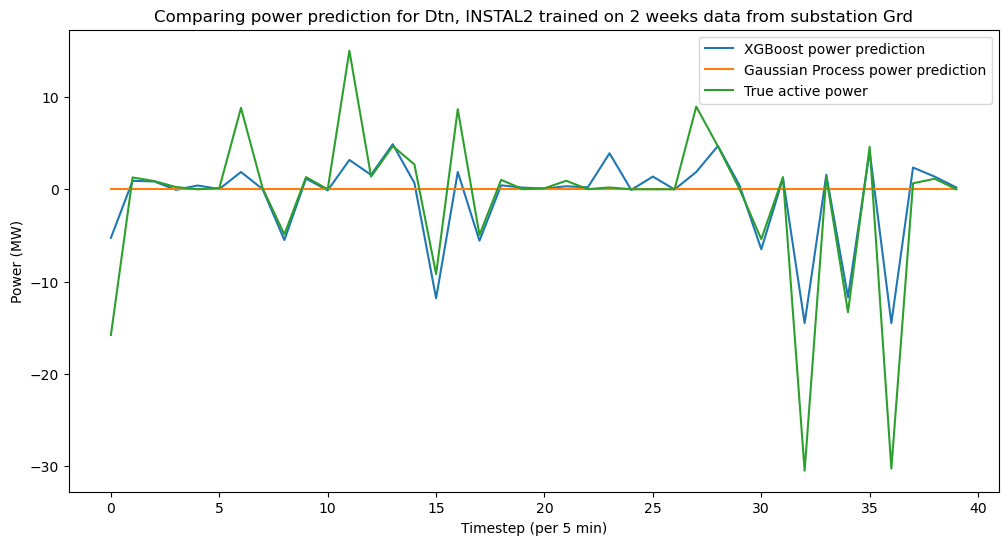

In [21]:
limit = 40
xg_pred_P = df_xg_predict["P_"+str(field_index)].to_list()[:limit]
gp_pred_P = df_gp_predict["P_"+str(field_index)].to_list()[:limit]
true_P = df_true_P["P_"+str(field_index)].to_list()[:limit]


plt.figure(figsize=(12,6))
plt.title("Comparing power prediction for Dtn, INSTAL2 trained on 2 weeks data from substation Grd")
plt.plot(xg_pred_P, label='XGBoost power prediction')
plt.plot(gp_pred_P, label='Gaussian Process power prediction')
plt.plot(true_P, label = 'True active power')
plt.legend()
plt.xlabel("Timestep (per 5 min)")
plt.ylabel("Power (MW)")
plt.savefig('spatial_2weeks.png')
plt.show()

In [17]:
true_P

[-15.8,
 1.28,
 0.89,
 0.24,
 0.0,
 0.13,
 8.82,
 0.09,
 -4.89,
 1.32,
 0.0,
 15.02,
 1.37,
 4.68,
 2.69,
 -9.19,
 8.68,
 -4.95,
 1.02,
 0.01,
 0.11,
 0.92,
 0.01,
 0.2,
 0.0,
 0.0,
 0.0,
 8.96,
 4.66,
 0.0,
 -5.4,
 1.32,
 -30.51,
 1.32,
 -13.32,
 4.6,
 -30.28,
 0.65,
 1.14,
 0.0]